# Laboratorium

### Konfiguracja

In [149]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import math
from copy import deepcopy
from functools import cmp_to_key

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.3

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

def compute_determinant_with_numpy(matrix):
    np_array = np.array(matrix) 
    return np.linalg.det(np_array)

def get_determinant_3x3(a, b, c, method):
    return method([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])

def numpy_get_determinant_3x3(a, b, c):
    return get_determinant_3x3(a, b, c, compute_determinant_with_numpy)

def orient(a, b, c):
    return numpy_get_determinant_3x3(a, b, c)

def angle3pt(a, b, c):
    """Counterclockwise angle in degrees by turning from a to c around b
        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
        math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [150]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, polygonalArea = None, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.polygonalArea = polygonalArea
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.16)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure(figsize=(9.5,9.5), dpi= 100, facecolor='w', edgecolor='k')
        self.callback = _Button_callback(self.scenes, self.polygonalArea)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [151]:
# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, polygonalArea):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []
        self.polygonalArea = polygonalArea

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
   
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        if self.polygonalArea:
            self.polygonalArea.processMouseEvent(event)
            self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if self.polygonalArea:
            self.added_points, self.added_lines = self.polygonalArea.toPlotCollections()
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [152]:
class PlotDecorator():
    
    def __init__(self, decorationSettings = {}):
        self.polPointSize = decorationSettings['poligonPointSize'] if \
             ('poligonPointSize' in decorationSettings) else 40
        self.polPointColor = decorationSettings['poligonPointColor'] if \
             ('poligonPointColor' in decorationSettings) else '#000000'
        self.polLineSize = decorationSettings['poligonLineSize'] if \
            ('poligonLineSize' in decorationSettings) else 2
        self.polLineColor = decorationSettings['poligonLineColor'] if \
            ('poligonLineColor' in decorationSettings) else '#000000'
        self.divLinePointSize = decorationSettings['divLinePointSize'] if \
            ('divLinePointSize' in decorationSettings) else 40
        self.divLinePointColor = decorationSettings['divLinePointColor'] if \
            ('divLinePointColor' in decorationSettings) else '#7F7F7F'
        self.divLineLineSize = decorationSettings['divLineLineSize'] if \
            ('divLineLineSize' in decorationSettings) else 2
        self.divLineLineColor = decorationSettings['divLineLineColor'] if \
            ('divLineLineColor' in decorationSettings) else '#7F7F7F'
            
    def plotDataToPlotCollections(self, plotData):
        points = []
        points.append(PointsCollection(deepcopy(plotData['polygonsPoints']),
                                       s=self.polPointSize, color=self.polPointColor))
        points.append(PointsCollection(deepcopy(plotData['divLinePoints']),
                                       s=self.divLinePointSize, color=self.divLinePointColor))
        lines = []
        lines.append(LinesCollection(deepcopy(plotData['polygonsLines']),
                                       linewidth=self.polLineSize, color=self.polLineColor))
        lines.append(LinesCollection(deepcopy(plotData['divLineLines']),
                                       linewidth=self.divLineLineSize, color=self.divLineLineColor))
        return (points, lines)

AREA_X_RANGE = [-100, 100]
AREA_Y_RANGE = [-100, 100]
PARTS_PER_SIDE_OF_AREA = 10

class PolygonalArea:
    
    def __init__(self):
        self.points = []
        self.polygons = []
        self.onSplitting = False
        self.clickTolerance = 0.0
        self.curDivLine = []
        self.plotDecorator = PlotDecorator()
        self.initArea(AREA_X_RANGE, AREA_Y_RANGE, PARTS_PER_SIDE_OF_AREA)
        
    def clear(self):
        self.points = []
        self.polygons = []
        
    def initArea(self, areaXRange, areaYRange, partsPerSideOfArea):
        self.clear()
        pointsIndicies = []
        partLength = (areaXRange[1] - areaXRange[0]) / partsPerSideOfArea
        for i in range(partsPerSideOfArea):
            pointsIndicies.append(self.addPoint([areaXRange[0] + i * partLength, areaYRange[0]]))
        partLength = (areaYRange[1] - areaYRange[0]) / partsPerSideOfArea
        for i in range(partsPerSideOfArea):
            pointsIndicies.append(self.addPoint([areaXRange[1], areaYRange[0] + i * partLength]))
        partLength = (areaXRange[1] - areaXRange[0]) / partsPerSideOfArea
        for i in range(partsPerSideOfArea):
            pointsIndicies.append(self.addPoint([areaXRange[1] - i * partLength, areaYRange[1]]))
        partLength = (areaYRange[1] - areaYRange[0]) / partsPerSideOfArea
        for i in range(partsPerSideOfArea):
            pointsIndicies.append(self.addPoint([areaXRange[0], areaYRange[1] - i * partLength]))
        self.createPolygonFromPoints(pointsIndicies)
        self.clickTolerance = max(areaXRange[1] - areaXRange[0], areaYRange[1] - areaYRange[0]) / 70
        
    def addPoint(self, pointsCords):
        if pointsCords not in self.points:
            self.points.append(deepcopy(pointsCords))
        return self.points.index(pointsCords)
    
    def getPointAtIndex(self, pointIndex):
        return deepcopy(self.points[pointIndex])
    
    def getIndexOfPoint(self, pointCords):
        return self.points.index(pointCords)
    
    def createPolygonFromPoints(self, pointsIndicies):
        self.polygons.append(deepcopy(pointsIndicies))
        
    def getAllPolygons(self):
        return [[self.getPointAtIndex(index) for index in polygon] for polygon in self.polygons]
        
    def toPlotData(self):
        plotData = {}
        polygonsPoints = self.getAllPolygons()
        plotData['polygonsPoints'] = [point for polygon in polygonsPoints for point in polygon]
        plotData['polygonsLines'] = [[polygon[index], polygon[(index + 1) % len(polygon)]]
                                     for polygon in polygonsPoints
                                     for index in range(len(polygon))]
        plotData['divLinePoints'] = [self.getPointAtIndex(pointId) for pointId in self.curDivLine]
        plotData['divLineLines'] = [[self.getPointAtIndex(self.curDivLine[pointId]),
                                     self.getPointAtIndex(self.curDivLine[pointId + 1])] 
                                    for pointId in range(len(self.curDivLine) - 1)]
        return plotData
    
    def getPolygonsWithPoint(self, pointIndex):
        pointsOfPolygons = []
        for polId in range(len(self.polygons)):
            polygon = self.polygons[polId]
            for pointId in range(len(polygon)):
                if polygon[pointId] == pointIndex:
                    pointsOfPolygons.append([polId, pointId])
        return pointsOfPolygons
    
    def getPolygonToSplit(self, polygonsForBegin):
        for polIdPointId in polygonsForBegin:
            polygon = self.polygons[polIdPointId[0]]
            polAngle = angle3pt(self.getPointAtIndex(polygon[(polIdPointId[1] + 1) % len(polygon)]),
                               self.getPointAtIndex(polygon[(polIdPointId[1] + 0) % len(polygon)]),
                               self.getPointAtIndex(polygon[(polIdPointId[1] - 1) % len(polygon)]))
            divLineAngle = angle3pt(self.getPointAtIndex(polygon[(polIdPointId[1] + 1) % len(polygon)]),
                               self.getPointAtIndex(polygon[(polIdPointId[1] + 0) % len(polygon)]),
                               self.getPointAtIndex(self.curDivLine[1]))
            if 0.0 < divLineAngle < polAngle:
                return polIdPointId
        return None
    
    def splitPolygonIntoTwo(self, polygonToSplitFromPoint):
        polygon = self.polygons[polygonToSplitFromPoint[0]]
        firstPolygon = deepcopy(self.curDivLine)
        beginPointIdInPol = polygon.index(firstPolygon[0])
        endPointIdInPol = polygon.index(firstPolygon[-1])
        i = endPointIdInPol
        while i != beginPointIdInPol:
            firstPolygon.append(polygon[i])
            i = (i + 1) % len(polygon)
        secondPolygon = deepcopy(list(reversed(self.curDivLine)))
        i = beginPointIdInPol
        while i != endPointIdInPol:
            secondPolygon.append(polygon[i])
            i = (i + 1) % len(polygon)
        self.polygons[polygonToSplitFromPoint[0]] = firstPolygon
        self.polygons.append(secondPolygon)
    
    def processDivLine(self):
        polygonsForBegin = self.getPolygonsWithPoint(self.curDivLine[0])
        toSplit = self.getPolygonToSplit(polygonsForBegin)
        if toSplit == None or self.curDivLine[-1] not in self.polygons[toSplit[0]]:
            self.curDivLine = []
            return
        self.splitPolygonIntoTwo(toSplit)
        self.curDivLine = []
    
    def processClickedPoint(self, clickedPoint):
        selPolId, selPointId = -1, -1
        for polId in range(len(self.polygons)):
            polygon = self.polygons[polId]
            for pointId in range(len(polygon)):
                point = self.getPointAtIndex(polygon[pointId])
                if dist(point, clickedPoint) < self.clickTolerance:
                    selPolId = polId
                    selPointId = pointId
                    break
        if self.onSplitting:
            if selPolId == -1:
                self.curDivLine.append(self.addPoint(clickedPoint))
            else:
                self.curDivLine.append(self.polygons[selPolId][selPointId])
                self.processDivLine()
                self.onSplitting = False
        else:
            if selPointId != -1:
                self.onSplitting = True
                self.curDivLine.append(self.polygons[selPolId][selPointId])
    
    def processMouseEvent(self, event):
        clickedPoint = (event.xdata, event.ydata)
        self.processClickedPoint(clickedPoint)
        
    def toPlotCollections(self):
        return self.plotDecorator.plotDataToPlotCollections(self.toPlotData())
        
        
        

<IPython.core.display.Javascript object>


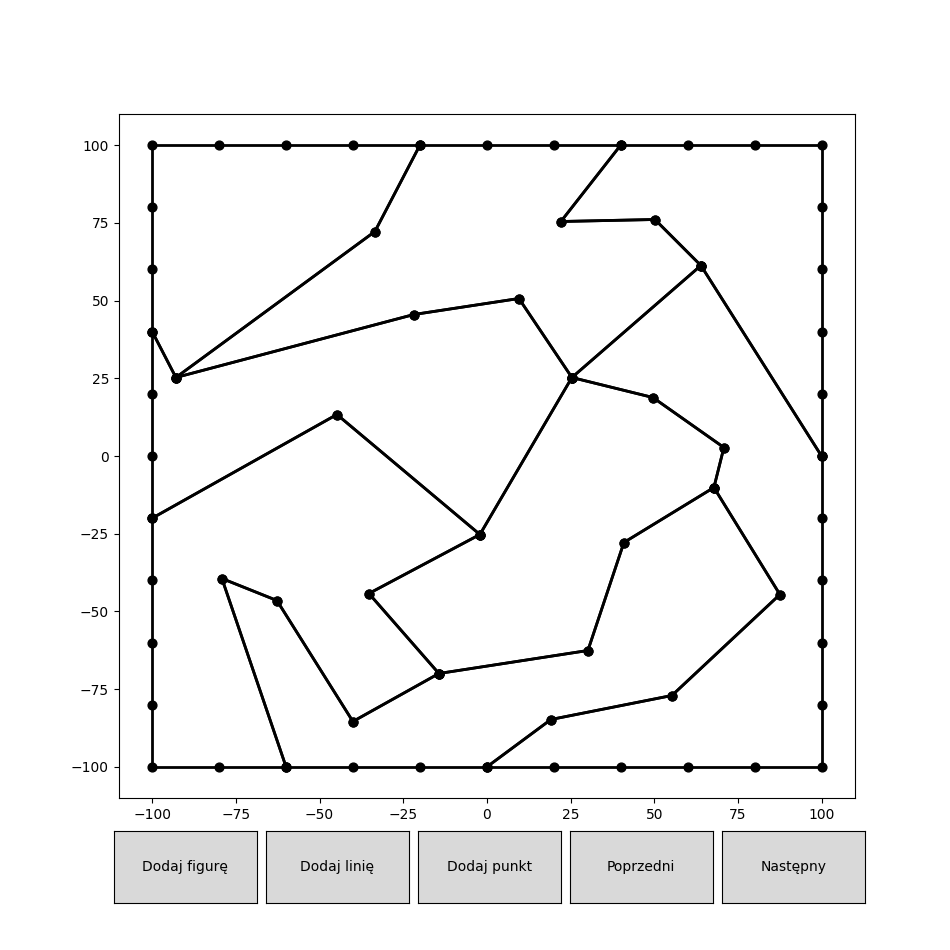

In [153]:
%matplotlib notebook

polygonalArea = PolygonalArea()
points, lines = polygonalArea.toPlotCollections()
scenes=[Scene(points=points, lines=lines)]

plot = Plot(polygonalArea = polygonalArea)
plot.draw()

In [300]:
def split_figure(subfigures, points_to_split):
    subfigures.append(deepcopy(points_to_split))
    for i in range(len(points_to_split)):
        if i != 0 and i != len(points_to_split) - 1:
            if points_to_split[i] in subfigures[0]:
                subfigures[0].remove(points_to_split[i])
            
def split_into_monotonic_figures(figure_points, points_classification, subfigures, subfigures_points_classes):
    for point_index in points_classification['con'] + points_classification['div']:
        temp_figure_left = [point_index]
        temp_figure_right = [point_index]
        for i in range(len(figure_points) // 2 - 1):
            if i == 0:
                continue
            temp_figure_left.insert(0, (len(figure_points) + point_index - i) % len(figure_points))
            temp_figure_right.append((len(figure_points) + point_index + i) % len(figure_points))
            if i < 2:
                continue
            if temp_figure_left[0] not in subfigures[0]:
                del temp_figure_left[0]
            if temp_figure_right[-1] not in subfigures[0]:
                del temp_figure_right[-1]
            temp_figure_left_points = [figure_points[i] for i in temp_figure_left]
            if temp_figure_left[0] not in points_classification['con'] + points_classification['div'] \
                and (point_index in points_classification['con'] and figure[point_index][1] > figure[temp_figure_left[0]][1] \
                     or point_index in points_classification['div'] and figure[point_index][1] < figure[temp_figure_left[0]][1]) \
                and is_poolygon_y_monotonic(temp_figure_left_points):
                split_figure(subfigures, temp_figure_left)
                subfigures_points_classes.append(clasify_points_of_figure(temp_figure_left_points))
                break
            temp_figure_right_points = [figure_points[i] for i in temp_figure_right]
            if temp_figure_right[-1] not in points_classification['con'] + points_classification['div'] \
                and (point_index in points_classification['con'] and figure[point_index][1] > figure[temp_figure_right[-1]][1] \
                     or point_index in points_classification['div'] and figure[point_index][1] < figure[temp_figure_right[-1]][1]) \
                and is_poolygon_y_monotonic(temp_figure_right_points):
                split_figure(subfigures, temp_figure_right)
                subfigures_points_classes.append(clasify_points_of_figure(temp_figure_right_points))
                break
    temp_figure_main_points = [figure_points[i] for i in subfigures[0]]
    subfigures_points_classes.insert(0, clasify_points_of_figure(temp_figure_main_points))
    
def compute_triangulation_for_subfigure(figure_points, subfigure, subfigure_points_classes, animation, figures_to_draw):
    triangulation = []
    start_index = subfigure_points_classes['beg'][0]
    end_index = subfigure_points_classes['end'][0]
    temp_left_part = []
    cur_index_i = start_index
    while cur_index_i != end_index:
        temp_left_part.append(subfigure[cur_index_i])
        cur_index_i = (len(subfigure) + cur_index_i - 1) % len(subfigure)
    temp_right_part = []
    cur_index_i = start_index
    while cur_index_i != end_index:
        temp_right_part.append(subfigure[cur_index_i])
        cur_index_i = (len(subfigure) + cur_index_i + 1) % len(subfigure)
    parts = [temp_right_part + [subfigure[end_index]], temp_left_part + [subfigure[end_index]]]
    sorted_subfigure = sorted(subfigure, key=lambda x: (figure_points[x][1], figure_points[x][0]), reverse=True)
    alg_queue = [sorted_subfigure[0], sorted_subfigure[1]]
    sorted_index = 2
    while sorted_index != len(sorted_subfigure):
        if (sorted_subfigure[sorted_index] in parts[0]) != (alg_queue[-1] in parts[0]):
            alg_queue.append(sorted_subfigure[sorted_index])
            while len(alg_queue) > 2:
                triangulation.append([alg_queue[0], alg_queue[1], alg_queue[-1]])
                del alg_queue[0]
                
        else:
            if sorted_subfigure[sorted_index] in parts[0]:
                while len(alg_queue) > 1:
                    if orient(figure_points[alg_queue[-2]], figure_points[alg_queue[-1]], figure_points[sorted_subfigure[sorted_index]]) < 0:
                        break
                    else:
                        triangulation.append([alg_queue[-2], alg_queue[-1], sorted_subfigure[sorted_index]])
                        del alg_queue[-1]
            else:
                while len(alg_queue) > 1:
                    if orient(figure_points[alg_queue[-2]], figure_points[alg_queue[-1]], figure_points[sorted_subfigure[sorted_index]]) > 0:
                        break
                    else:
                        triangulation.append([alg_queue[-2], alg_queue[-1], sorted_subfigure[sorted_index]])
                        del alg_queue[-1]
            alg_queue.append(sorted_subfigure[sorted_index])
        sorted_index += 1
    for triang_id in range(len(triangulation)):
        triangulation[triang_id].sort()
        figures_to_draw.append(LinesCollection([[figure_points[triangulation[triang_id][i % 3]] for i in range(4)]], color='#00bf00'))
        animation.append(Scene(lines=deepcopy(figures_to_draw)))
    return triangulation

def compute_triangulation(figure_points):
    subfigures = [[i for i in range(len(figure_points))]]
    points_classification = clasify_points_of_figure(figure_points)
    subfigures_points_classes = []
    split_into_monotonic_figures(figure_points, points_classification, subfigures, subfigures_points_classes)
    animation = []
    triangulations = []
    figures_to_draw = [LinesCollection([[figure_points[subfigure[i % len(subfigure)]] \
                                       for i in range(len(subfigure) + 1)]], color='#0000bf', linewidth=3) \
                       for subfigure in subfigures]
    animation.append(Scene(lines=deepcopy(figures_to_draw)))
    for index in range(len(subfigures)):
        triangulations.append(compute_triangulation_for_subfigure(figure_points, subfigures[index], subfigures_points_classes[index], animation, figures_to_draw))
    print(triangulations)
    return (subfigures, animation, triangulations)

[[[1, 2, 3], [4, 5, 6], [3, 4, 6], [0, 6, 7], [0, 3, 6], [0, 1, 3]]]


<IPython.core.display.Javascript object>


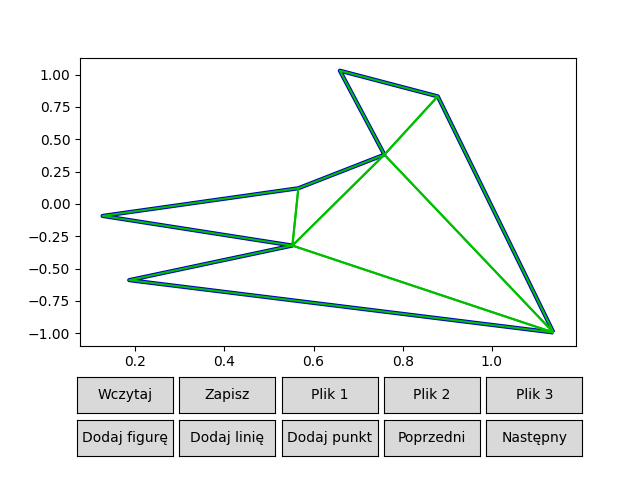

In [313]:
%matplotlib notebook

plot = _Button_callback([])
plot.draw_plot = False
plot.load_from_file(None)
figure = deepcopy(plot.figures[0])
(subfigures, animation, triangulations) = compute_triangulation(figure)

plot = Plot(scenes = animation)
plot.draw()

[[[0, 1, 2], [0, 2, 4], [0, 4, 27], [4, 5, 27], [5, 20, 27], [5, 9, 20], [9, 17, 20], [17, 19, 20], [17, 18, 19]], [[6, 7, 8], [6, 8, 9], [5, 6, 9]], [[24, 25, 26]], [[2, 3, 4]], [[9, 10, 11]], [[9, 11, 17], [11, 12, 17], [12, 16, 17], [12, 13, 16], [13, 14, 16], [14, 15, 16]], [[20, 26, 27], [20, 21, 26], [21, 24, 26], [21, 22, 24], [22, 23, 24]]]


<IPython.core.display.Javascript object>


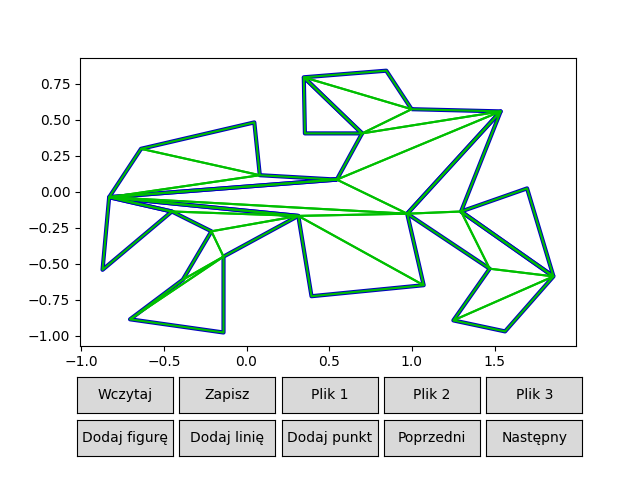

In [312]:
%matplotlib notebook

plot = _Button_callback([])
plot.draw_plot = False
plot.select_file_2(None)
plot.load_from_file(None)
figure = deepcopy(plot.figures[0])
(subfigures, animation, triangulations) = compute_triangulation(figure)

plot = Plot(scenes = animation)
plot.draw()

[[[1, 2, 3], [1, 3, 4], [0, 1, 4], [0, 4, 30], [4, 5, 30], [5, 29, 30], [5, 6, 29], [6, 28, 29], [6, 27, 28], [6, 7, 27], [7, 21, 27], [7, 20, 21], [7, 8, 20], [8, 15, 20], [8, 14, 15], [8, 9, 14], [9, 10, 14], [10, 13, 14], [10, 11, 13], [11, 12, 13]], [[23, 24, 25], [22, 23, 25], [22, 25, 26], [22, 26, 27], [21, 22, 27]], [[15, 16, 20], [16, 17, 20], [17, 19, 20], [17, 18, 19]]]


<IPython.core.display.Javascript object>


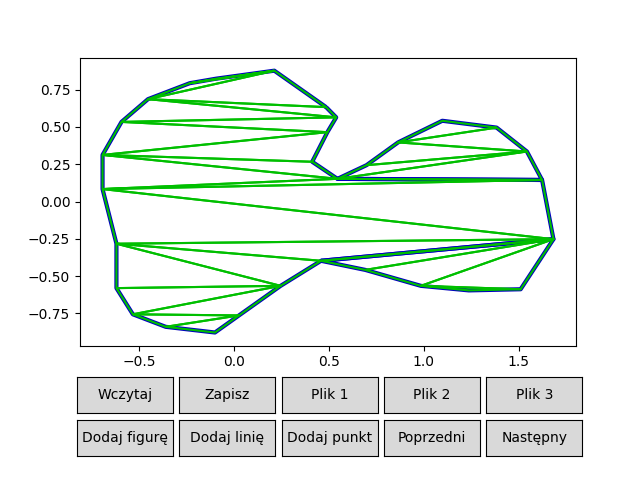

In [311]:
%matplotlib notebook

plot = _Button_callback([])
plot.draw_plot = False
plot.select_file_3(None)
plot.load_from_file(None)
figure = deepcopy(plot.figures[0])
(subfigures, animation, triangulations) = compute_triangulation(figure)

plot = Plot(scenes = animation)
plot.draw()